In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
# %matplotlib qt
%matplotlib inline



def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray =img
    # Calculate directional gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))

    if orient == 'x':
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))


    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1


    return grad_binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary



def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    theta = np.arctan2(abs_sobely, abs_sobelx)

#     normalize
#     theta = np.uint8(theta/(np.max(theta)/255))

    scaled_theta = np.uint8(theta/np.max(theta/255))

    # 5) Create a binary mask where direction thresholds are met
#     binary_output = np.zeros_like(theta)
    dir_binary = np.zeros_like(scaled_theta)
    dir_binary[(theta >= thresh[0]) & (theta <= thresh[1])] = 1
    return dir_binary



def hist(image):
    bottom_half = image[image.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, leftx_base, rightx_base, midpoint


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, leftx_base, rightx_base, midpoint = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
# 
    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     print(leftx.size)
#     print(rightx.size)

    return out_img, ploty, left_fit, right_fit, leftx, lefty, rightx, righty, leftx_base, rightx_base, midpoint


def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
#     ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return left_curverad, right_curverad


def measure_curvature_real(ploty, left_fit, right_fit, leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Make sure to feed in your real data instead in your project!
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
#     ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    y_left_eval = np.max(lefty)
    y_right_eval = np.max(righty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    # left_curverad = 0  ## Implement the calculation of the left line here
    # right_curverad = 0  ## Implement the calculation of the right line here
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_left_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_right_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curv = np.average([left_curverad, right_curverad])
    
#     return left_curverad, right_curverad
#     return 'Left_R: {:.2f} m, Right_R:{:.2f} m'.format(left_curverad, right_curverad)
    return 'Curvature Radius: {:.2f} m'.format(avg_curv)


def real_mid_offset(leftx_base, rightx_base, midpoint):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    current_lane_midpoint = np.average([leftx_base, rightx_base])
    mid_offset = current_lane_midpoint - midpoint
    real_mid_offset = mid_offset * xm_per_pix
    
    if real_mid_offset >= 0: return 'Center Offset: {:.2f} m Left of Center'.format(real_mid_offset)
    else: return 'Center Offset: {:.2f} m Right of Center'.format(np.abs(real_mid_offset))
    
    
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    return result, left_fitx, right_fitx, ploty, out_img










In [2]:
# def process_image(image):
#     fileName = '../test_images/test5.jpg'
#     image = mpimg.imread(fileName)
fileName = '../test_images/test4.jpg'
image = mpimg.imread(fileName)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


# RGB
# R_RGB_thresh = (218, 255)# N
R_RGB = image[:, :, 0]
G_RGB = image[:, :, 1]
B_RGB = image[:, :, 2]

R_RGB_thresh = (218, 255)# N
R_binary = np.zeros_like(R_RGB)
R_binary[(R_RGB <= R_RGB_thresh[1]) & (R_RGB >= R_RGB_thresh[0])] = 1
R_binary_RGB = R_binary


G_RGB_thresh = (185, 255)
G_binary = np.zeros_like(G_RGB)
G_binary[(G_RGB <= G_RGB_thresh[1]) & (G_RGB >= G_RGB_thresh[0])] = 1 ## <<-------- Interfere with R binary selection
G_binary_RGB = G_binary

B_RGB_thresh = (46, 68)
B_binary = np.zeros_like(B_RGB)
B_binary[(B_RGB <= B_RGB_thresh[1]) & (B_RGB >= B_RGB_thresh[0])] = 1 ## <<-------- Interfere with R binary selection
B_binary_RGB = B_binary



#LAB
brightLAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
L_LAB = np.abs(brightLAB[:,:,0])/np.max(np.abs(brightLAB[:,:,0]))
A_LAB = np.abs(brightLAB[:,:,1])/np.max(np.abs(brightLAB[:,:,1]))# <-------8,7,5 ,4l
B_LAB = np.abs(brightLAB[:,:,2])/np.max(np.abs(brightLAB[:,:,2]))# <-------8,7, 5, 4l
#     L_thresh = (.83,1)
#     L_binary = np.zeros_like(L)
#     L_binary[(L <= L_thresh[1]) & (L >= L_thresh[0])] = 1
#     L_binary_LAB = L_binary
# A_LAB_thresh = (0,.71)
A_LAB_thresh = (0,.61)
A_binary = np.zeros_like(A_LAB)
A_binary[(A_LAB <= A_LAB_thresh[1]) & (A_LAB >= A_LAB_thresh[0])] = 1
A_binary_LAB = A_binary

B_LAB_thresh = (0,.60)
B_binary = np.zeros_like(B_LAB)
B_binary[(B_LAB <= B_LAB_thresh[1]) & (B_LAB >= B_LAB_thresh[0])] = 1
# B_binary_LAB = B_binary

B_binary_LAB = abs_sobel_thresh(B_binary, orient='x', sobel_kernel=7, thresh=(25, 255)) #<--------added Apr8-#<---------



# HLS

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H_HLS = hls[:,:,0]
L_HLS = hls[:,:,1]
S_HLS = hls[:,:,2]
S_HLS_thresh = (190,255)
S_binary = np.zeros_like(S_HLS)
S_binary[(S_HLS <= S_HLS_thresh[1]) & (S_HLS >= S_HLS_thresh[0])] = 1
S_binary_HLS = S_binary



#HSV

brightHSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
H_HSV = brightHSV[:,:,0]
S_HSV = brightHSV[:,:,1]# <-------8,5
V_HSV = brightHSV[:,:,2]#7,6

S_HSV_thresh = (120,255)
S_binary = np.zeros_like(S_HSV)
S_binary[(S_HSV <= S_HSV_thresh[1]) & (S_HSV >= S_HSV_thresh[0])] = 1
S_binary_HSV = S_binary

#     V_thresh = (.82,1)
V_HSV_thresh = (200,255)
V_binary = np.zeros_like(V_HSV)
V_binary[(V_HSV <= V_HSV_thresh[1]) & (V_HSV >= V_HSV_thresh[0])] = 1
V_binary_HSV = V_binary



V_HSV_thresh2 = (0, 194)
# V_HSV_thresh2 = (0, 208)
V_binary_HSV2 = np.zeros_like(V_HSV)
V_binary_HSV2[(V_HSV >= V_HSV_thresh2[0]) & (V_HSV <= V_HSV_thresh2[1])] = 1
# plt.imshow(V_binary_HSV, cmap='gray')
# H_HSV_thresh = (99, 105)
# H_binary_HSV = np.zeros_like(H_HSV)
# H_binary_HSV[(H_HSV <= H_HSV_thresh[1]) & (H_HSV >= H_HSV_thresh[0])] = 1
# # H_binary_HSV 
# plt.imshow(H_binary_HSV, cmap='gray')





#YCRB
ycrb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
Y_YCRB = ycrb[:,:,0]#6RL, 4RL
Cr_YCRB = ycrb[:,:,1]# <-------8,7,5
Cb_YCRB = ycrb[:,:,2]# <-------8,5
#     Cr_thresh = (.38,.44)
#     Cr_binary = np.zeros_like(Cr)
#     Cr_binary[(Cr <= Cr_thresh[1]) & (Cr >= Cr_thresh[0])] = 1
#     Cr_binary_YCRB = Cr_binary
#     Cb_thresh = (.54,1)
#     Cb_binary = np.zeros_like(Cb)
#     Cb_binary[(Cb <= Cb_thresh[1]) & (Cb >= Cb_thresh[0])] = 1
#     Cb_binary_YCRB = Cb_binary
#     Cr_thresh = (.38,.44)
Cr_YCRB_thresh = (0, 102)
Cr_binary = np.zeros_like(Cr_YCRB)
Cr_binary[(Cr_YCRB <= Cr_YCRB_thresh[1]) & (Cr_YCRB >= Cr_YCRB_thresh[0])] = 1
Cr_binary_YCRB = Cr_binary
#     Cb_thresh = (.56,1)

Cb_YCRB_thresh = (164, 255)
Cb_binary = np.zeros_like(Cb_YCRB)
Cb_binary[(Cb_YCRB <= Cb_YCRB_thresh[1]) & (Cb_YCRB >= Cb_YCRB_thresh[0])] = 1
Cb_binary_YCRB = Cb_binary



# combined
# B_binary_LAB <<<<------LAB 
# V_binary_HSV <<<<<<<<<<<<<DELETE THIS WE WILL NOT USING THIS

# S_binaryHSV  <<<<<<<<<<<<< DELETE THIS WE WILL NOT USING THIS
# Cb_binary_YCRB

# Cr_binary_YCRB
# R_binary_RGB <----RGB

# A_binary_LAB <<<<------LAB
# S_binary_HLS  <<<<----







# combined
# B_binary_LAB <<<<------LAB 
# Cb_binary_YCRB

# Cr_binary_YCRB
# R_binary_RGB <----RGB

# A_binary_LAB <<<<------LAB
# S_binary_HLS  <<<<----

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
#1
# B_binary_LAB
# Cb_binary_YCRB
color_binary1 = np.dstack((np.zeros_like(B_binary_LAB), B_binary_LAB, Cb_binary_YCRB)) * 255
combined_binary1 = np.zeros_like(Cb_binary_YCRB)
combined_binary1[(B_binary_LAB == 1) & (Cb_binary_YCRB == 1)] = 1  

#2
# Cr_binary_YCRB
# R_binary_RGB <----RGB
color_binary2 = np.dstack((np.zeros_like(R_binary_RGB), R_binary_RGB, Cr_binary_YCRB)) * 255
combined_binary2 = np.zeros_like(Cr_binary_YCRB)
combined_binary2[(R_binary_RGB == 1) | (Cr_binary_YCRB == 1)] = 1

#3 
# A_binary_LAB <<<<------LAB
# S_binary_HLS  <<<<---- AND S_binary_HLS
color_binary3 = np.dstack((np.zeros_like(A_binary_LAB), A_binary_LAB, S_binary_HLS)) * 255
combined_binary3 = np.zeros_like(S_binary_HLS)
combined_binary3[((A_binary_LAB == 1) & (B_binary_LAB==1)) & (S_binary_HLS == 1)] = 1

# #4 
# color_binary4 = np.dstack((np.zeros_like(A_binary_LAB), A_binary_LAB, B_binary_RGB))
# combined_binary4 = np.zeros_like(B_binary_RGB)
# combined_binary4[(A_binary_LAB == 1) | (B_binary_RGB == 1)] = 1

# ----------


# combined 1 and 2
color_binary_1n2 = np.dstack((np.zeros_like(combined_binary1), combined_binary1, combined_binary2)) * 255
combined_binary_1n2 = np.zeros_like(combined_binary2)
combined_binary_1n2[(combined_binary1 == 1) | (combined_binary2 == 1)] = 1

# # Combine 3 and 4!
# color_binary_3n4 = np.dstack((np.zeros_like(combined_binary3), combined_binary3, combined_binary4))
# combined_binary_3n4 = np.zeros_like(combined_binary4)
# combined_binary_3n4[(combined_binary3 == 1) | (combined_binary4 == 1)] = 1

#Final 1n2 and 3
color_binary_f = np.dstack((np.zeros_like(combined_binary_1n2), combined_binary_1n2, combined_binary3)) * 255
combined_binary_f = np.zeros_like(combined_binary3)
combined_binary_f[(combined_binary_1n2 == 1) | (combined_binary3 == 1)] = 1


# ----------------------


# thresh = (44, 140)
# thresh = (199, 220)

# V_HSV_thresh = (200,255)
# V_binary = np.zeros_like(V_HSV)
# V_binary[(V_HSV <= V_HSV_thresh[1]) & (V_HSV >= V_HSV_thresh[0])] = 1
# V_binary_HSV = V_binary

# # V_HSV
# binary_a3 = np.zeros_like(V_HSV)
# binary_a3[(V_HSV > thresh[0]) & (V_HSV <= thresh[1])] = 1
# a3 = np.zeros_like(binary_a3)
# a3[binary_a3 != 1] = 1
# a3 = V_binary_HSV
# Sx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(45, 255))
Sx_binary1 = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(25, 255))

Sx_binary = abs_sobel_thresh(Sx_binary1, orient='x', sobel_kernel=7, thresh=(25, 255)) #<--------Added apr92021-#<---------



combined_test = np.zeros_like(Sx_binary)
combined_test[(Sx_binary == 1) & (V_binary_HSV2 != 1)] = 1
# plt.imshow(combined_test)



# COMBINED2
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
# color_binary_a1a2 = np.dstack(( np.zeros_like(a3), a3, Sx_binary)) * 255

# # Combine the two binary thresholds
# combined_binary_a1a2 = np.zeros_like(a3)
# # combined_binary_a1a2[(Sx_binary == 1) | (a3 ==1)] = 1
# combined_binary_a1a2[(Sx_binary == 1)] = 1

# combined_binary_a1a2 = Sx_binary
combined_binary_special = combined_test


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary_final = np.dstack((np.zeros_like(combined_binary_f), combined_binary_f, combined_binary_special)) * 255

# Combine the two binary thresholds
combined_binary_final = np.zeros_like(combined_binary_f)
combined_binary_final[(combined_binary_f == 1) | (combined_binary_special == 1)] = 1
# combined_binary_final = combined_binary_f


########################





# ############


#     # Stack each channel to view their individual contributions in green and blue respectively
#     # This returns a stack of the two binary images, whose components you can see as different colors
#     color_binary = np.dstack(( np.zeros_like(best_binary1), best_binary1, best_binary2)) * 255

#     # Combine the two binary thresholds
#     combined_binary = np.zeros_like(best_binary1)
#     combined_binary[(best_binary2 == 1) | (best_binary1 == 1)] = 1
#     best_final = combined_binary



# best_binary1 = combined_binary
#     best_final = combined_binary

img_size = (image.shape[1], image.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)
warped2 = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
# trythis = warped.copy()
trythis2 = image

warped = cv2.warpPerspective(combined_binary_final, M, img_size, flags=cv2.INTER_LINEAR)

img = warped/255
histogram = hist(img)
# plt.plot(histogram)

binary_warped = warped


out_img, ploty,left_fit, right_fit, leftx, lefty, rightx, righty, leftx_base, rightx_base, midpoint = fit_polynomial(binary_warped)
out_img2 = out_img # Draw line ine squuare box


# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty, out_img = search_around_poly(binary_warped, left_fit, right_fit)

# %matplotlib qt
# print(type(warped))
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

#     img_size = (warped.shape[1], warped.shape[0])



Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

warp2 = cv2.warpPerspective(warped2, Minv, (image.shape[1], image.shape[0]))

# return newwarp

real_mid_off = real_mid_offset(leftx_base, rightx_base, midpoint)
curv_R = measure_curvature_real(ploty, left_fit, right_fit, leftx, lefty, rightx, righty)


# Warp the blank back to original image space using inverse perspective matrix (Minv)
# result = cv2.warpPerspective(trythis2, Minv, (image.shape[1], image.shape[0])) 




# Combine the result with the original image
#     result = cv2.addWeighted(warp2, 1, newwarp, 0.3, 0)
#     plt.imshow(result)




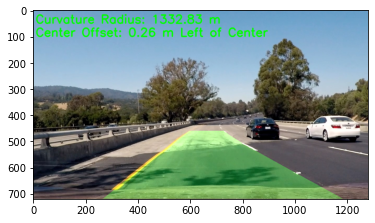

In [3]:
result_a = newwarp
result = cv2.addWeighted(image, 1, result_a, 0.3, 0)
# def process_image_end(img):
#     image = img
#     result_a = process_image(image)
#     result = cv2.addWeighted(image, 1, result_a, 0.3, 0)
#     return result

# fileName = '../test_images/test5.jpg'
# image = mpimg.imread(fileName)

# result =process_image_end(image)
# result_a =  process_image(image)
# result = cv2.addWeighted(image, 1, result_a, 0.3, 0)
final = np.copy(result)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, real_mid_off,(10,100), font, 1.5,(0,255,0),3,cv2.LINE_AA)
cv2.putText(result, curv_R ,(10,50), font, 1.5,(0,255,0),3,cv2.LINE_AA)

plt.imshow(result)
# process_image_end

# Save image:
# mpimg.imsave('../HC_test_images_output/straight_lines2_f.jpg', result)
# mpimg.imsave('../HC_test_images_output/straight_lines2_i.jpg', final)

# plt.savefig(r'\HC_test_images_output\test1.jpg')


# Select Colors
## RGB

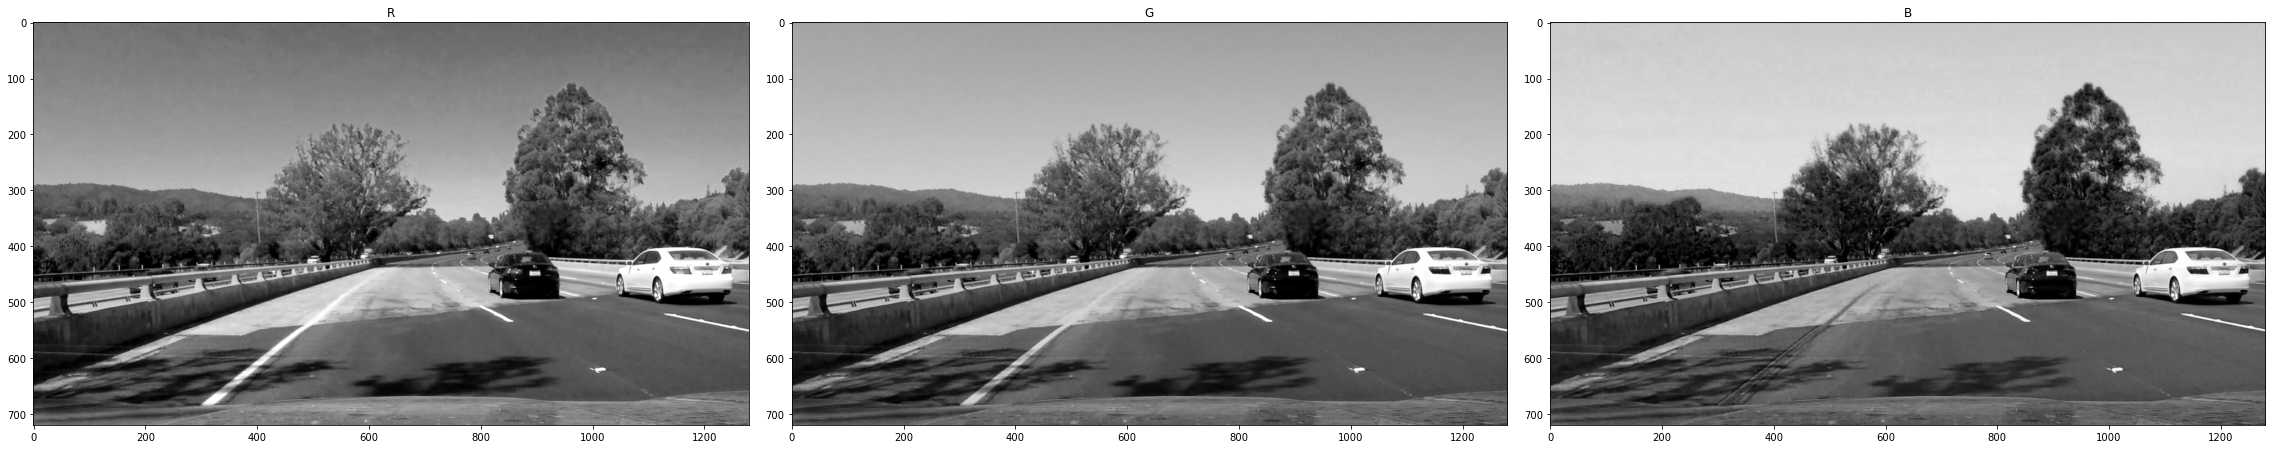

In [4]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(31, 11))
f.tight_layout()
ax1.imshow(R_RGB, cmap ='gray')
ax1.set_title('R')
ax2.imshow(G_RGB, cmap='gray')
ax2.set_title('G')
ax3.imshow(B_RGB, cmap='gray')
ax3.set_title('B')

plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)

# f.savefig('../output_images/RGB.jpg')

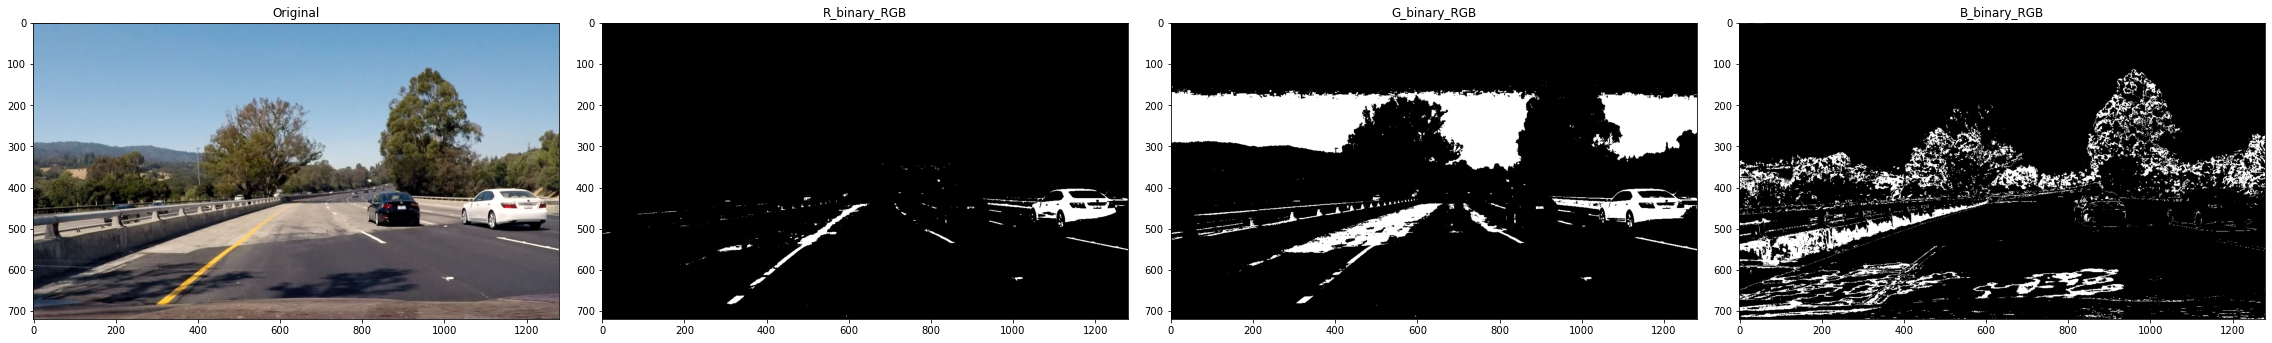

In [5]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(31, 11))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original')
ax2.imshow(R_binary_RGB, cmap='gray')
ax2.set_title('R_binary_RGB')
ax3.imshow(G_binary_RGB, cmap='gray')
ax3.set_title('G_binary_RGB')
ax4.imshow(B_binary_RGB, cmap='gray')
ax4.set_title('B_binary_RGB')#6


plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)

As a result, we can tell that the light at B_RGB shows shoadows create noise.
R_RGB can pick both yellow and white lane

# LAB 
 L*a*b* color values give us a way to locate and communicate colors
 
L*: Lightness

a*: Red/Green Value

b*: Blue/Yellow Value

## In LAB, B and A is used!
 

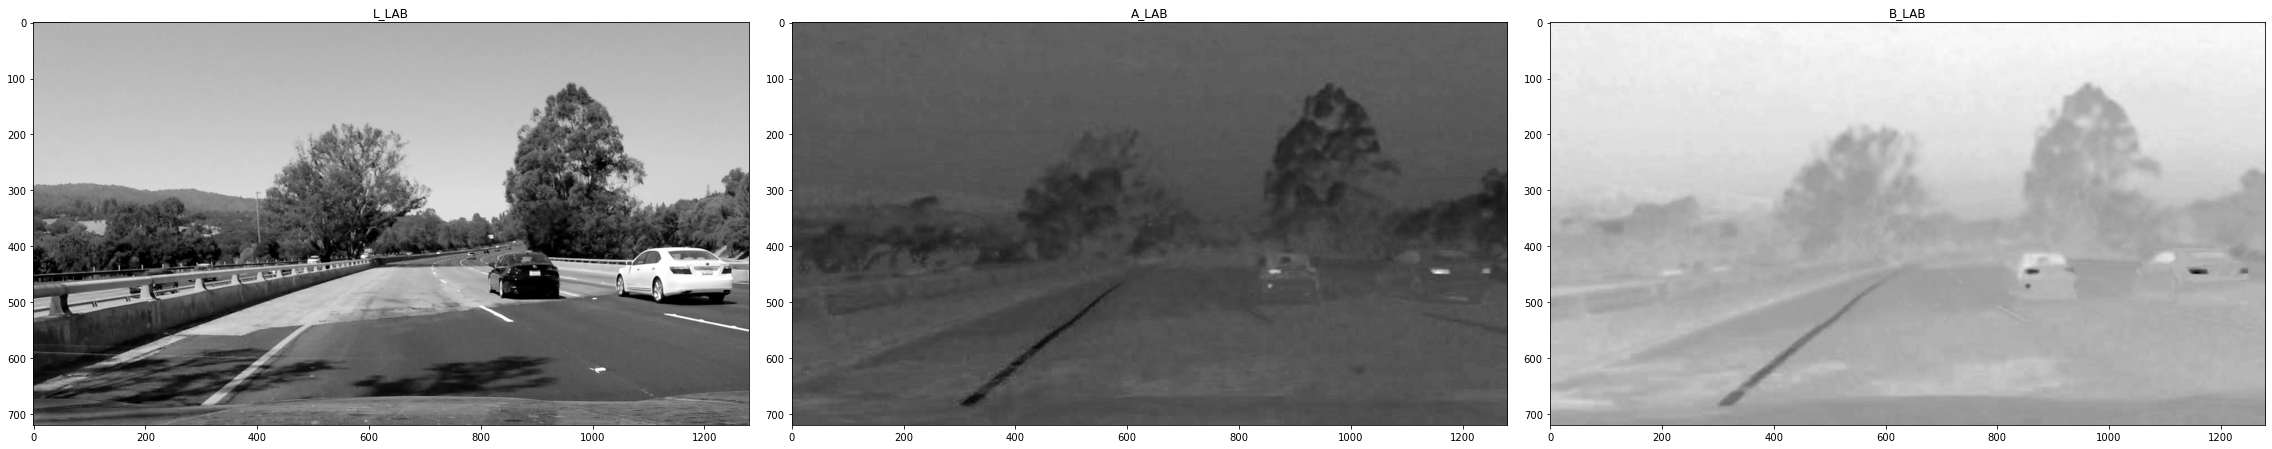

In [6]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(31, 11))
f.tight_layout()
ax1.imshow(L_LAB, cmap ='gray')
ax1.set_title('L_LAB')
ax2.imshow(A_LAB, cmap='gray')
ax2.set_title('A_LAB')
ax3.imshow(B_LAB, cmap='gray')
ax3.set_title('B_LAB')

plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)

# f.savefig('../output_images/LAB.jpg')


As you see A_LAB and B_LAB can pick yellow lane better. 


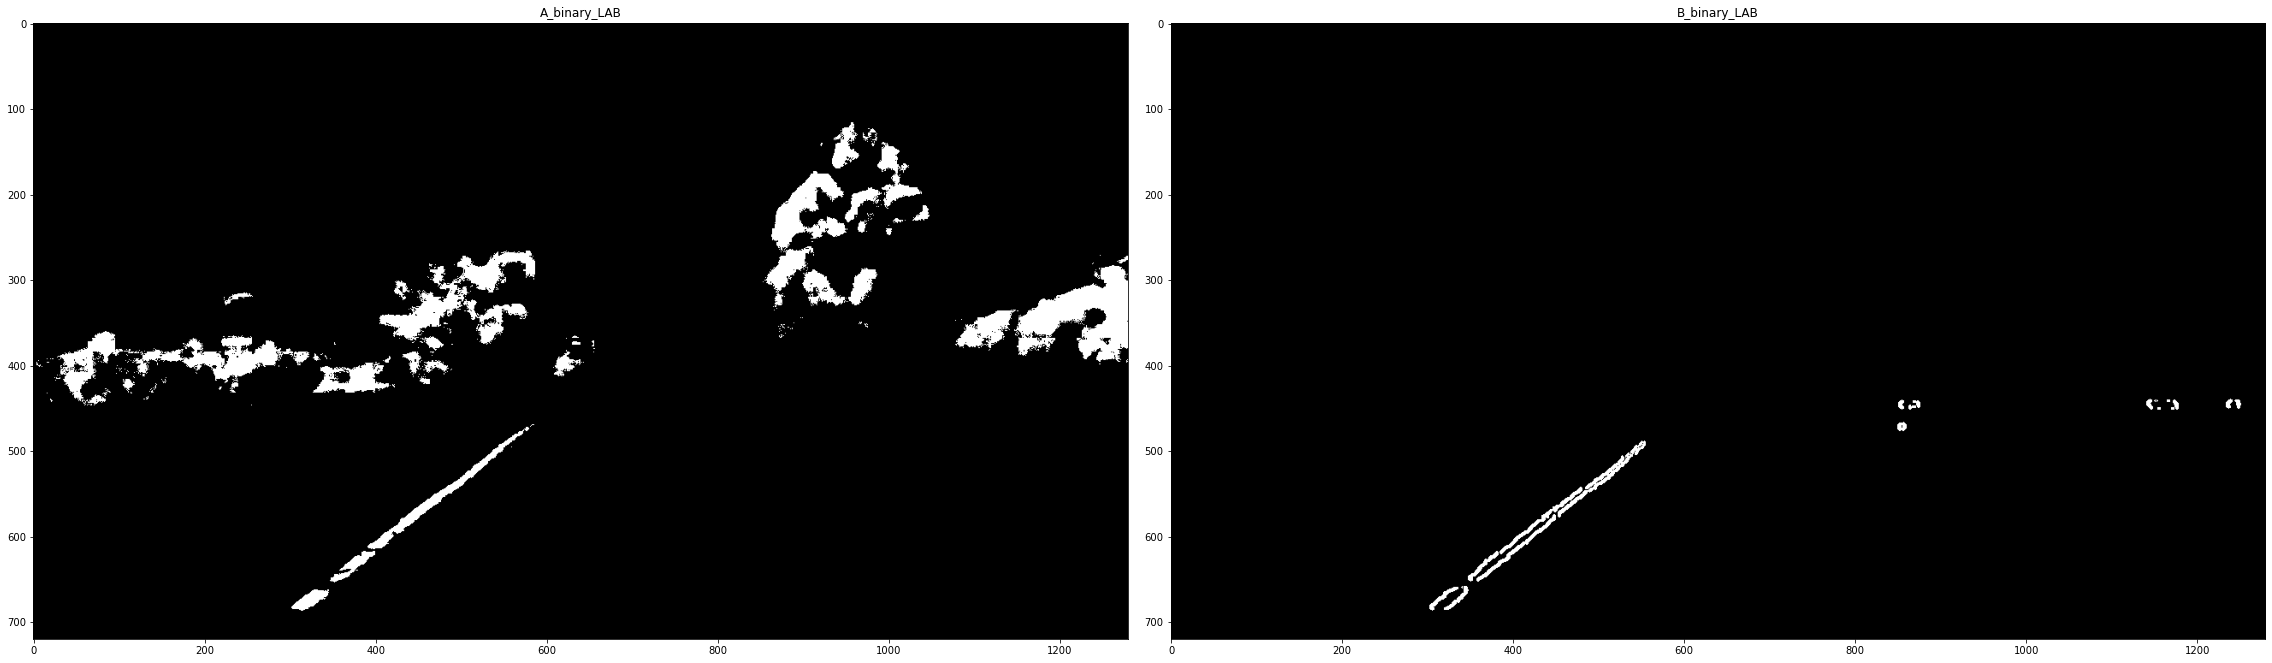

In [7]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(31, 11))
f.tight_layout()
ax1.imshow(A_binary_LAB, cmap ='gray')
ax1.set_title('A_binary_LAB')
ax2.imshow(B_binary_LAB, cmap='gray')
ax2.set_title('B_binary_LAB')


plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)

# HLS
HSL (hue, saturation, lightness)

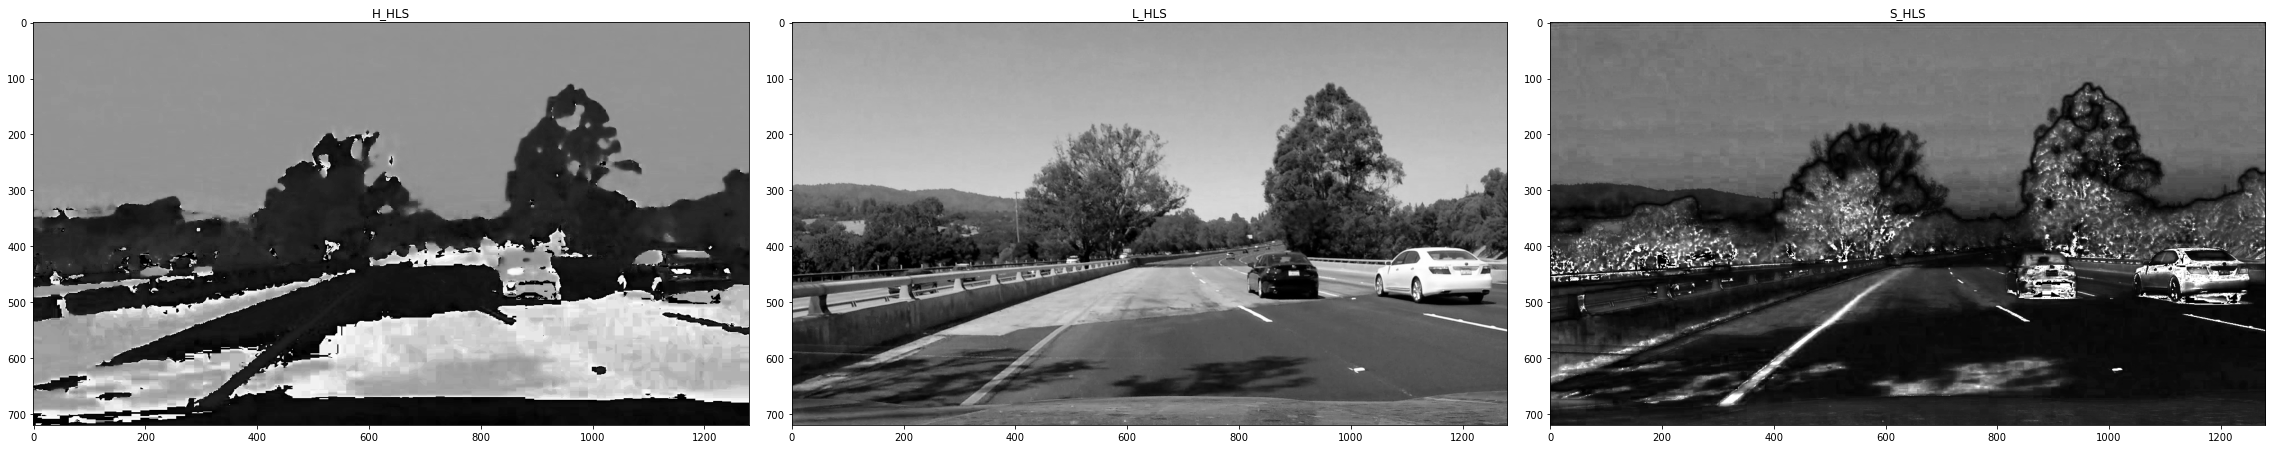

In [8]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(31, 11))
f.tight_layout()
ax1.imshow(H_HLS, cmap ='gray')
ax1.set_title('H_HLS')
ax2.imshow(L_HLS, cmap='gray')
ax2.set_title('L_HLS')
ax3.imshow(S_HLS, cmap='gray')
ax3.set_title('S_HLS')

plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)

# f.savefig('../output_images/HLS.jpg')

In HLS color

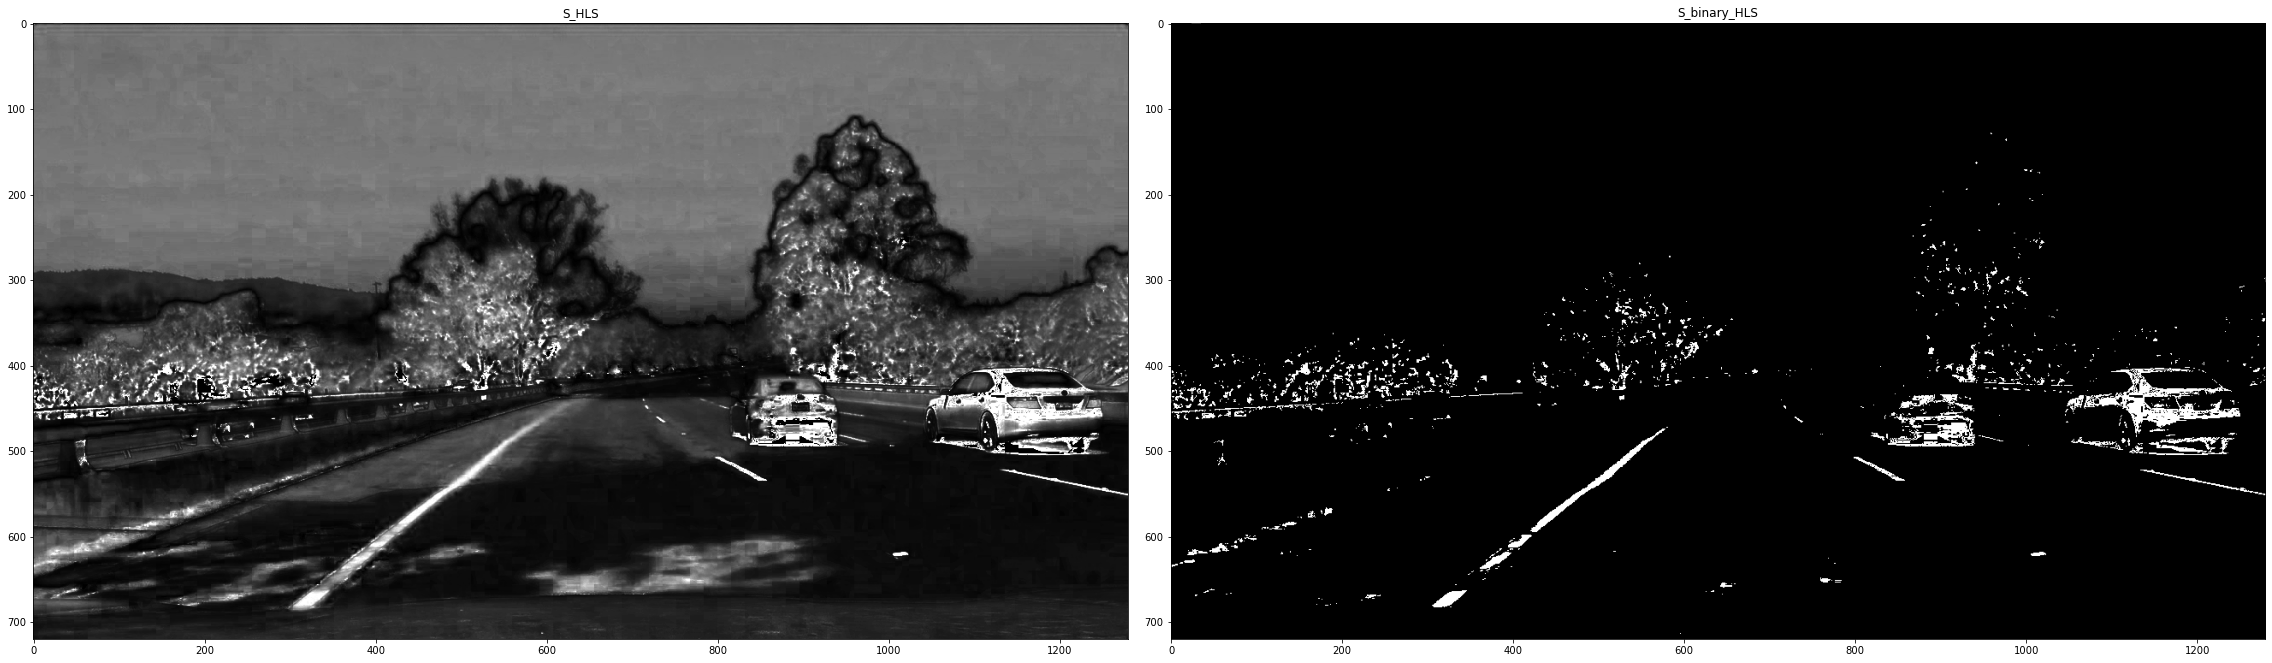

In [9]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(31, 11))
f.tight_layout()
ax1.imshow(S_HLS, cmap ='gray')
ax1.set_title('S_HLS')
ax2.imshow(S_binary_HLS, cmap='gray')
ax2.set_title('S_binary_HLS')


plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)

# HSV

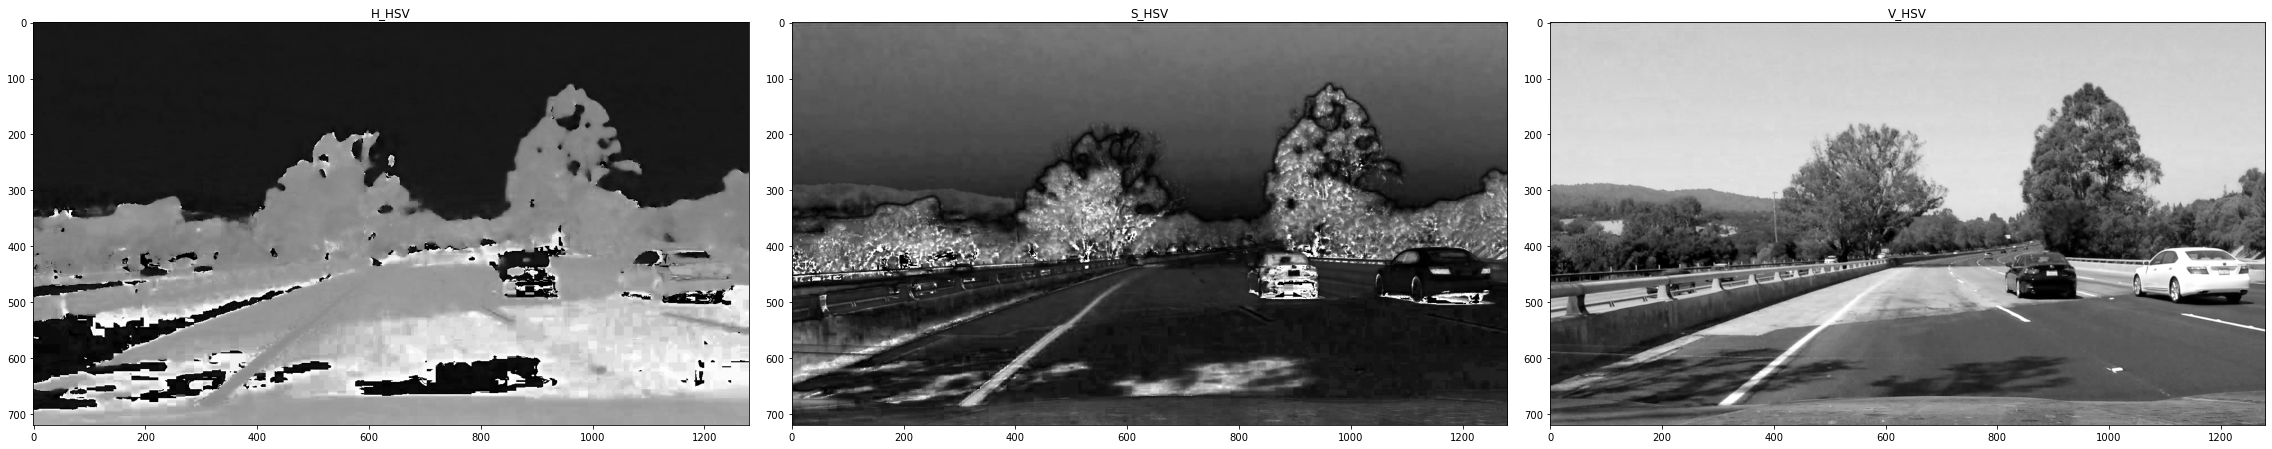

In [10]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(31, 11))
f.tight_layout()
ax1.imshow(H_HSV, cmap ='gray')
ax1.set_title('H_HSV')
ax2.imshow(S_HSV, cmap='gray')
ax2.set_title('S_HSV')
ax3.imshow(V_HSV, cmap='gray')
ax3.set_title('V_HSV')

plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)
# f.savefig('../output_images/HSV.jpg')

HSV color shows nothing much change compare to S_HSL adn R_RGB

In [11]:
# V_HSV_thresh = (0, 209)
# V_binary_HSV = np.zeros_like(V_HSV)
# V_binary_HSV[(V_HSV >= V_HSV_thresh[0]) & (V_HSV <= V_HSV_thresh[1])] = 1
# plt.imshow(V_binary_HSV, cmap='gray')
# H_HSV_thresh = (99, 105)
# H_binary_HSV = np.zeros_like(H_HSV)
# H_binary_HSV[(H_HSV <= H_HSV_thresh[1]) & (H_HSV >= H_HSV_thresh[0])] = 1
# # H_binary_HSV 
# plt.imshow(H_binary_HSV, cmap='gray')



# combined_test = np.zeros_like(Sx_binary)
# combined_test[(Sx_binary == 1) & (V_binary_HSV != 1)] = 1
# plt.imshow(combined_test)

# YCRB

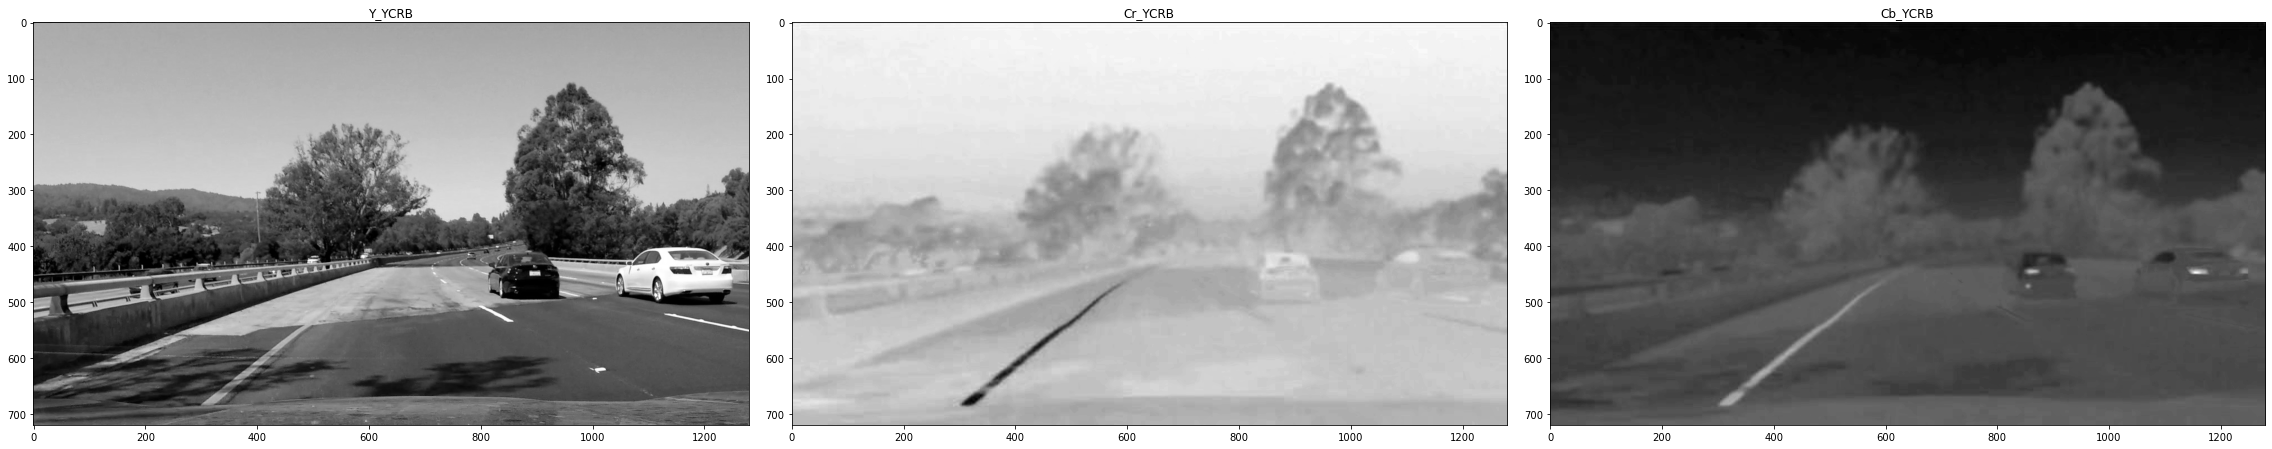

In [12]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(31, 11))
f.tight_layout()
ax1.imshow(Y_YCRB, cmap ='gray')
ax1.set_title('Y_YCRB')
ax2.imshow(Cr_YCRB, cmap='gray')
ax2.set_title('Cr_YCRB')
ax3.imshow(Cb_YCRB, cmap='gray')
ax3.set_title('Cb_YCRB')

plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)

# f.savefig('../output_images/YCRB.jpg')

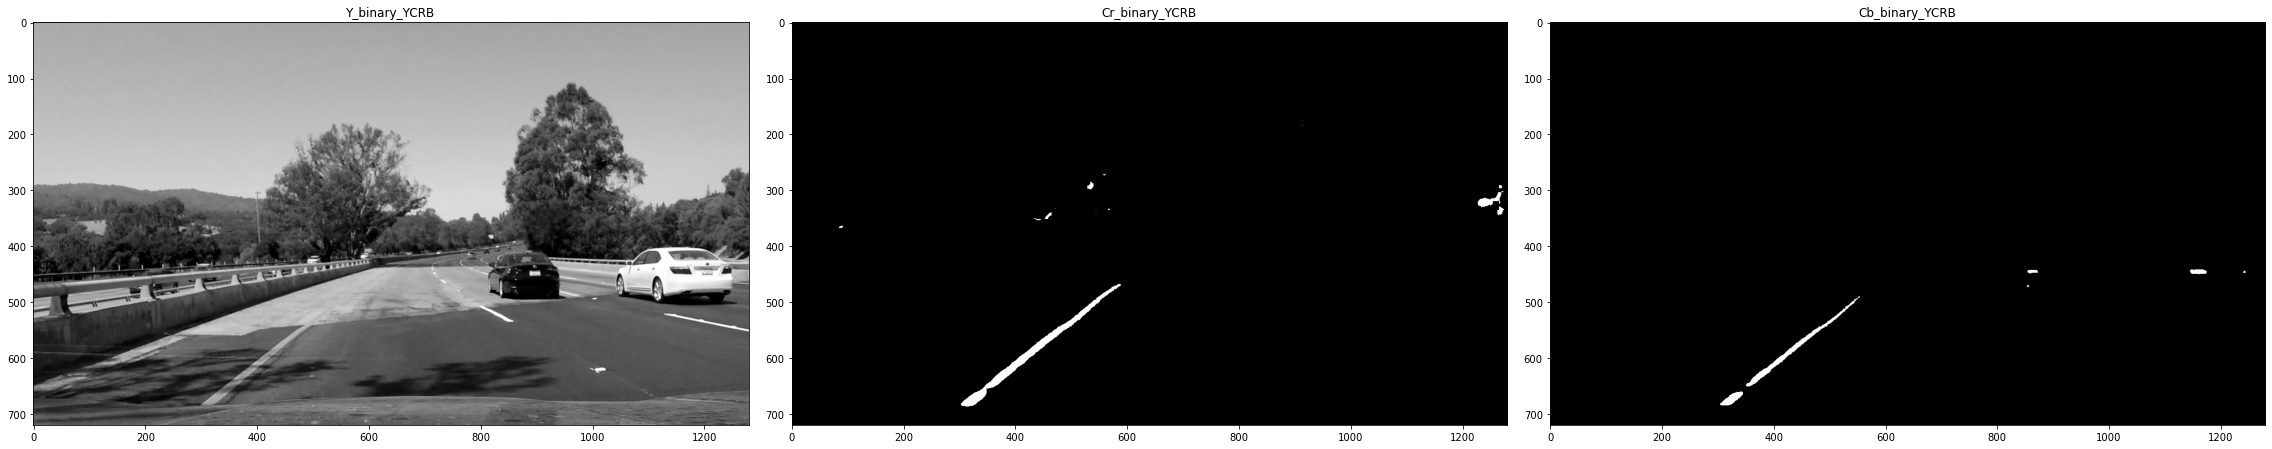

In [13]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(31, 11))
f.tight_layout()
ax1.imshow(Y_YCRB, cmap ='gray')
ax1.set_title('Y_binary_YCRB')
ax2.imshow(Cr_binary_YCRB, cmap ='gray')
ax2.set_title('Cr_binary_YCRB')
ax3.imshow(Cb_binary_YCRB, cmap='gray')
ax3.set_title('Cb_binary_YCRB')
# ax3.imshow(V_HSV, cmap='gray')
# ax3.set_title('V_HSV')

plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)

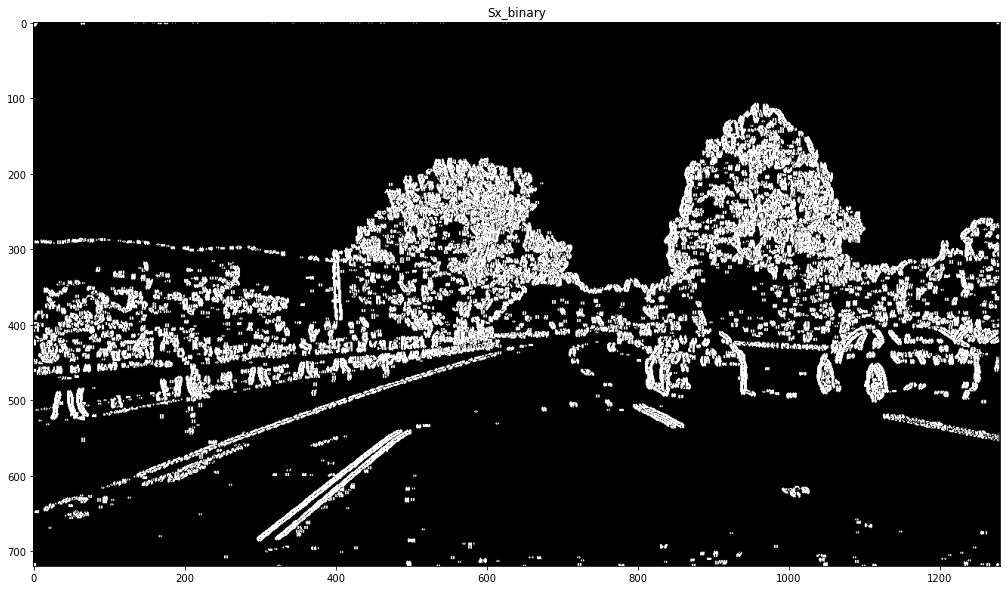

In [14]:
# Sx_binary



# Plotting thresholded images
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.set_title('Sx_binary')
ax1.imshow(Sx_binary, cmap='gray')



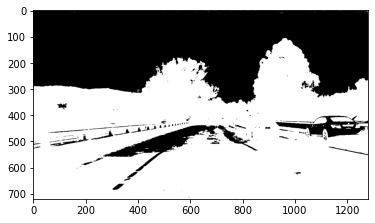

In [15]:
plt.imshow(V_binary_HSV2, cmap='gray')

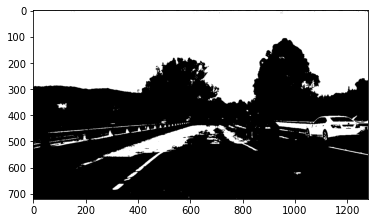

In [16]:
not_V_binart_HSV2 = np.zeros_like(V_binary_HSV2)
not_V_binart_HSV2[V_binary_HSV2 != 1] = 1
plt.imshow(not_V_binart_HSV2, cmap='gray')

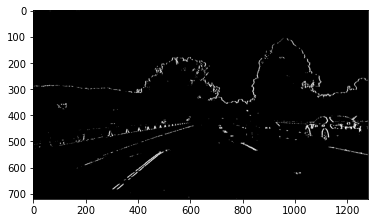

In [17]:
# combined_test = np.zeros_like(Sx_binary)
# combined_test[(Sx_binary == 1) & (V_binary_HSV2 != 1)] = 1
plt.imshow(combined_test, cmap='gray')

In [18]:
# plt.imshow(a3, cmap='gray')



# combined
# B_binary_LAB <<<<------LAB 
# Cb_binary_YCRB

# Cr_binary_YCRB
# R_binary_RGB <----RGB

# A_binary_LAB <<<<------LAB
# S_binary_HLS  <<<<----


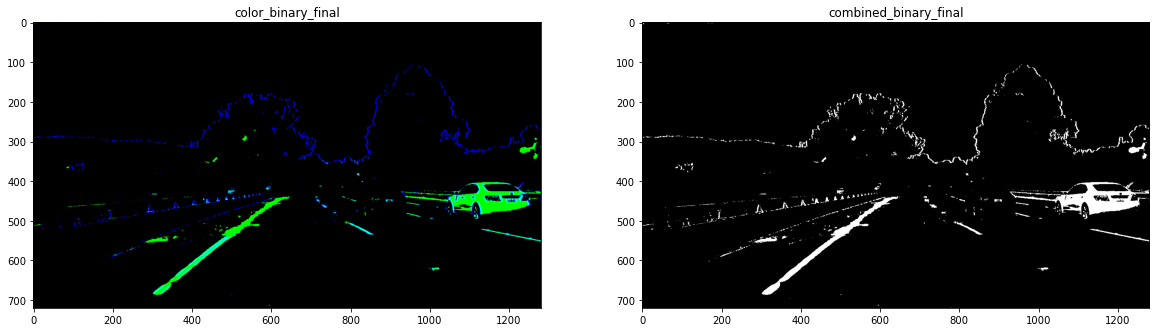

In [19]:


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('color_binary_final')
ax1.imshow(color_binary_final)

ax2.set_title('combined_binary_final')
ax2.imshow(combined_binary_final, cmap='gray')


# f.savefig('../output_images/color_binary_final.jpg')


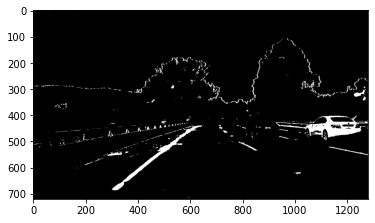

In [20]:


plt.imshow(color_binary_final)
# plt.savefig('../output_images/color_binary_final1.jpg')
# mpimg.imsave('../output_images/color_binary_final1.jpg', color_binary_final)



plt.imshow(combined_binary_final, cmap='gray')
# plt.savefig('../output_images/binary_final1.jpg')

# mpimg.imsave('../output_images/binary_final1.jpg', combined_binary_final, cmap='gray')



In [21]:


# # Plotting thresholded images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('color_binary_final')
# ax1.imshow(color_binary_final)

# ax2.set_title('combined_binary_final')
# ax2.imshow(combined_binary_final, cmap='gray')

In [22]:
# plt.imshow(combined_binary_f, cmap='gray')

In [23]:
# plt.imshow(combined_binary_1n2, cmap='gray')


In [24]:
# plt.imshow(combined_binary1, cmap='gray')


In [25]:
# plt.imshow(combined_binary2, cmap='gray')


In [26]:
# plt.imshow(B_binary_LAB, cmap='gray')

In [27]:
# plt.imshow(Cb_binary_YCRB, cmap='gray')

In [28]:
# gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# plt.imshow(abs_sobel_thresh(gray, orient='x', sobel_kernel=7, thresh=(25, 255)))

In [29]:
# tst = abs_sobel_thresh(Sx_binary, orient='x', sobel_kernel=7, thresh=(52, 155))
# plt.imshow(tst)

# plt.imshow(combined_binary3)

In [30]:
# combined_binary3[((A_binary_LAB == 1) | (B_binary_LAB==1)) | (S_binary_HLS == 1)] = 1


In [31]:
# plt.imshow(A_binary_LAB, cmap='gray')

In [32]:
# plt.imshow(B_binary_LAB, cmap='gray')

In [33]:
# plt.imshow(S_binary_HLS, cmap='gray')

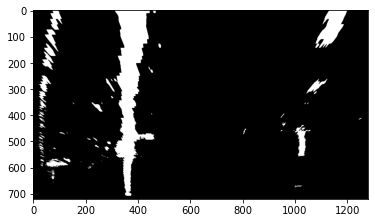

In [34]:
plt.imshow(warped, cmap='gray')

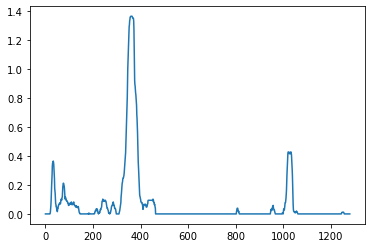

In [35]:
img = warped/255
histogram = hist(img)
plt.plot(histogram)


# Save image:
# plt.savefig('../output_images/histogram.jpg')



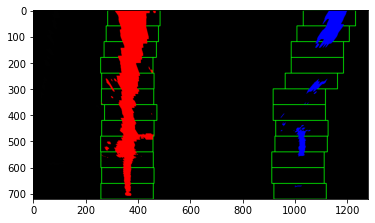

In [36]:
plt.imshow(out_img2)

# Save image:
# plt.savefig('../output_images/straight_out_img2.jpg')



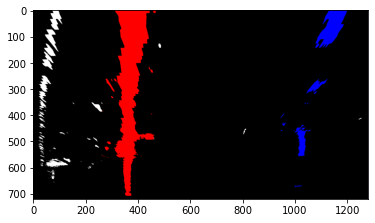

In [37]:
plt.imshow(out_img)


# Save image:
# plt.savefig('../output_images/straight_out_img.jpg')



In [38]:
# tst = abs_sobel_thresh(Sx_binary, orient='x', sobel_kernel=3, thresh=(11, 255))
# plt.imshow(tst)

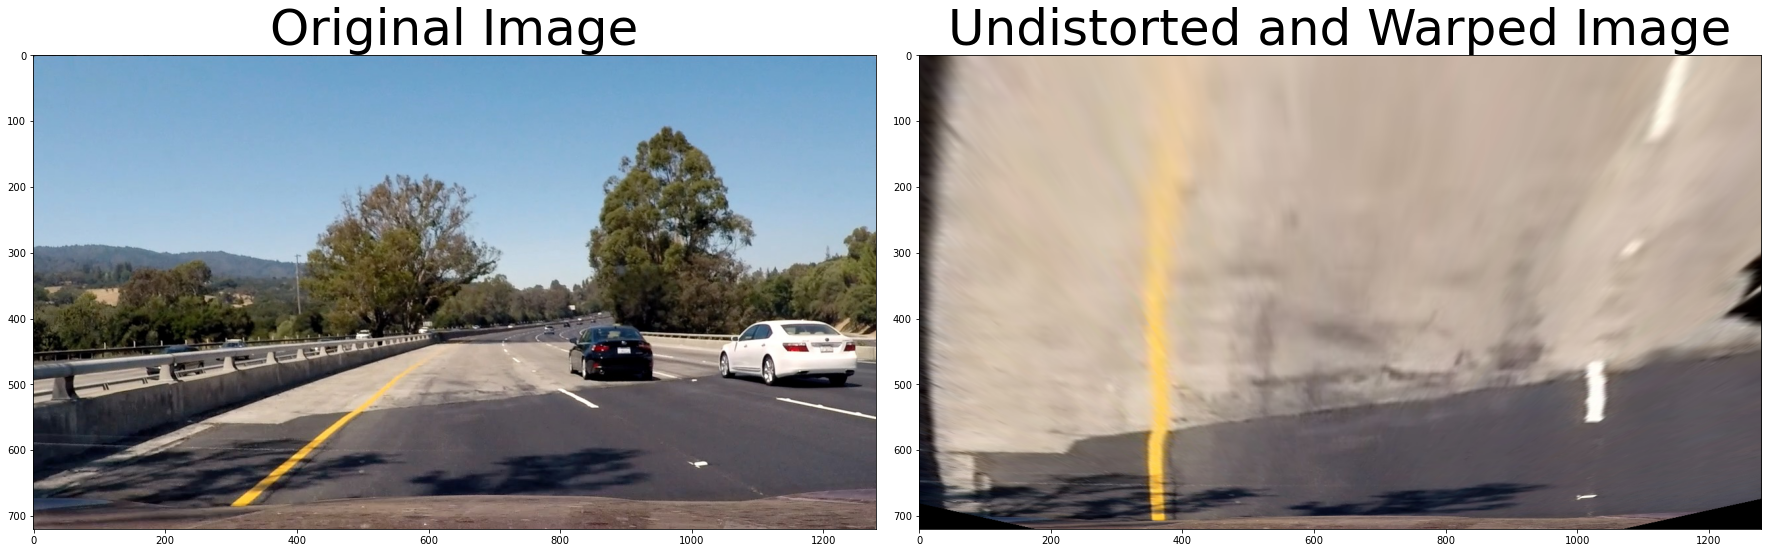

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped2)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# f.savefig('../output_images/orignal_and_undistorted_warped.jpg')


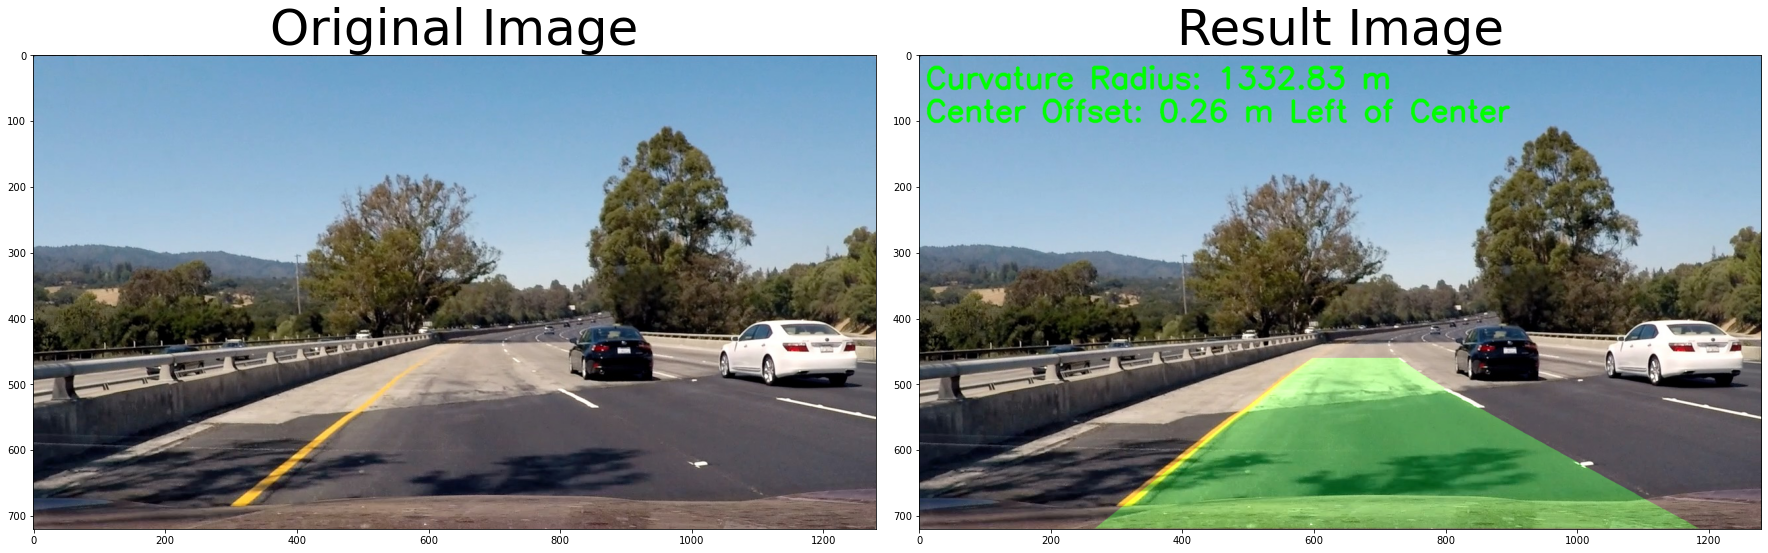

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('Result Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# f.savefig('../output_images/orignal_and_result.jpg')


In [41]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
#     ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    
    return left_curverad, right_curverad

In [42]:
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)

print(left_curverad, right_curverad)

6115.558191791502 2013.3700580880889


# Real value of Curvature
Let's say that our camera image has 720 relevant pixels in the y-dimension (remember, our image is perspective-transformed!), and we'll say roughly 700 relevant pixels in the x-dimension (our example of fake generated data above used from 200 pixels on the left to 900 on the right, or 700). Therefore, to convert from pixels to real-world meter measurements, we can use:

In [43]:
# def measure_curvature_real(ploty, left_fit, right_fit, leftx, lefty, rightx, righty):
#     '''
#     Calculates the curvature of polynomial functions in meters.
#     '''
#     # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
#     # Make sure to feed in your real data instead in your project!
#     left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
# #     ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
#     # Define y-value where we want radius of curvature
#     # We'll choose the maximum y-value, corresponding to the bottom of the image
#     y_eval = np.max(ploty)
#     y_left_eval = np.max(lefty)
#     y_right_eval = np.max(righty)
    
#     ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
#     # left_curverad = 0  ## Implement the calculation of the left line here
#     # right_curverad = 0  ## Implement the calculation of the right line here
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
# #     left_curverad = ((1 + (2*left_fit_cr[0]*y_left_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# #     right_curverad = ((1 + (2*right_fit_cr[0]*y_right_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     avg_curv = np.average([left_curverad, right_curverad])
    
# #     return left_curverad, right_curverad
# #     return 'Left_R: {:.2f} m, Right_R:{:.2f} m'.format(left_curverad, right_curverad)
#     return 'Curvature Radius: {:.2f} m'.format(avg_curv)

In [44]:
# Calculate the radius of curvature in meters for both lane lines
curvature = measure_curvature_real(ploty, left_fit, right_fit, leftx, lefty, rightx, righty)
curvature
# print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

'Curvature Radius: 1332.83 m'

In [45]:
real_mid_offset(leftx_base, rightx_base, midpoint)

'Center Offset: 0.26 m Left of Center'

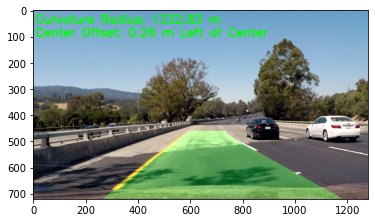

In [46]:
testimage = np.copy(result)
plt.imshow(testimage)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(testimage,real_mid_offset(leftx_base, rightx_base, midpoint),(10,100), font, 1.5,(0,255,0),3,cv2.LINE_AA)
cv2.putText(testimage,measure_curvature_real(ploty, left_fit, right_fit, leftx, lefty, rightx, righty),(10,50), font, 1.5,(0,255,0),3,cv2.LINE_AA)

plt.imshow(testimage)

# Combine Visual

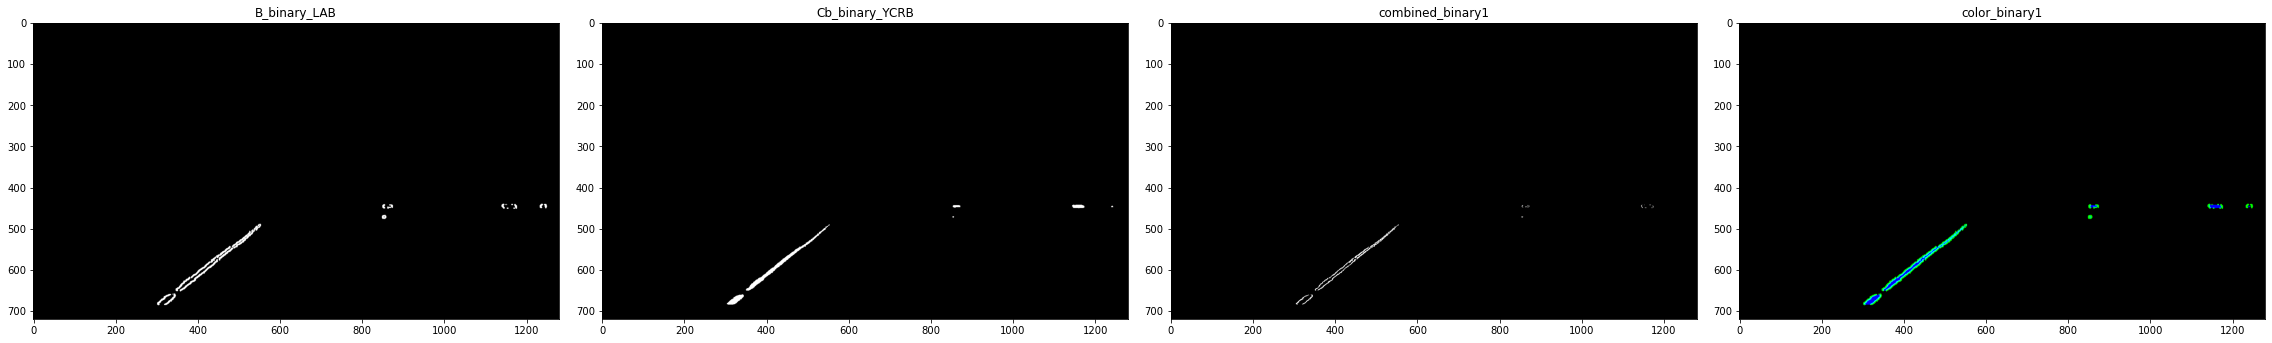

In [47]:
# combined 1 use 'and'
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(31, 11))
f.tight_layout()
ax1.imshow(B_binary_LAB, cmap ='gray')
ax1.set_title('B_binary_LAB')
ax2.imshow(Cb_binary_YCRB, cmap='gray')
ax2.set_title('Cb_binary_YCRB')
ax3.imshow(combined_binary1, cmap='gray')
ax3.set_title('combined_binary1')
ax4.imshow(color_binary1)
ax4.set_title('color_binary1')
plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)


# f.savefig('../output_images/combined1.jpg')





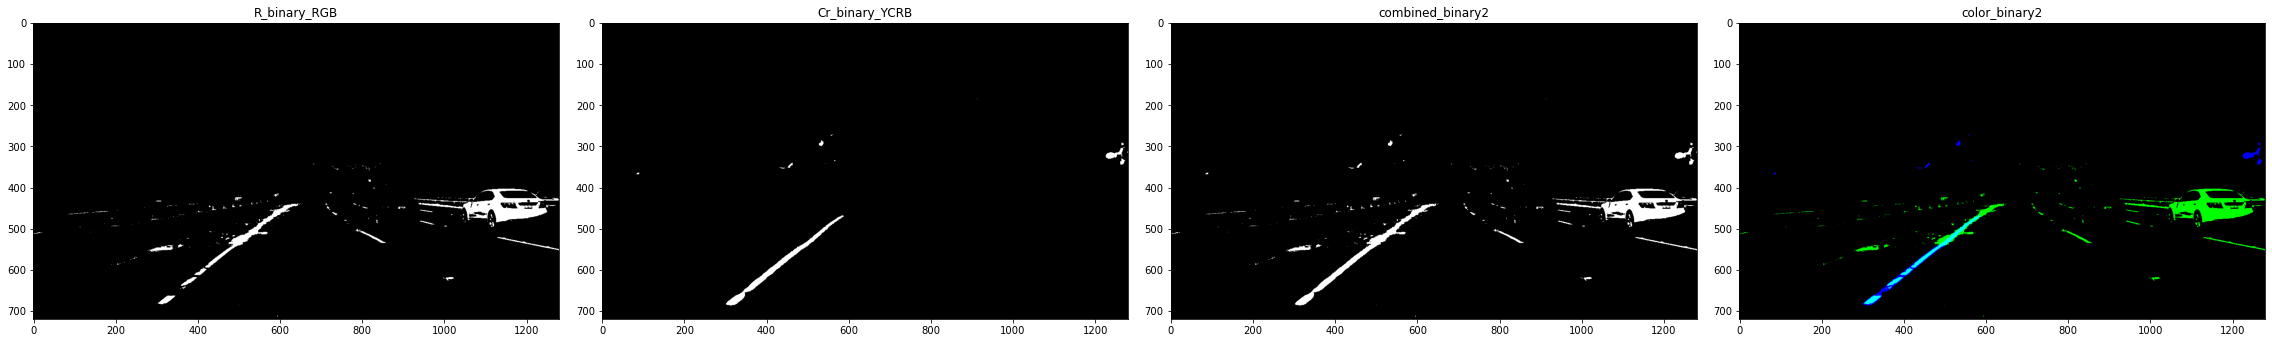

In [48]:
# combined 2 use or

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(31, 11))
f.tight_layout()
ax1.imshow(R_binary_RGB, cmap ='gray')
ax1.set_title('R_binary_RGB')
ax2.imshow(Cr_binary_YCRB, cmap='gray')
ax2.set_title('Cr_binary_YCRB')
ax3.imshow(combined_binary2, cmap='gray')
ax3.set_title('combined_binary2')
ax4.imshow(color_binary2)
ax4.set_title('color_binary2')
plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)


# f.savefig('../output_images/combined2.jpg')





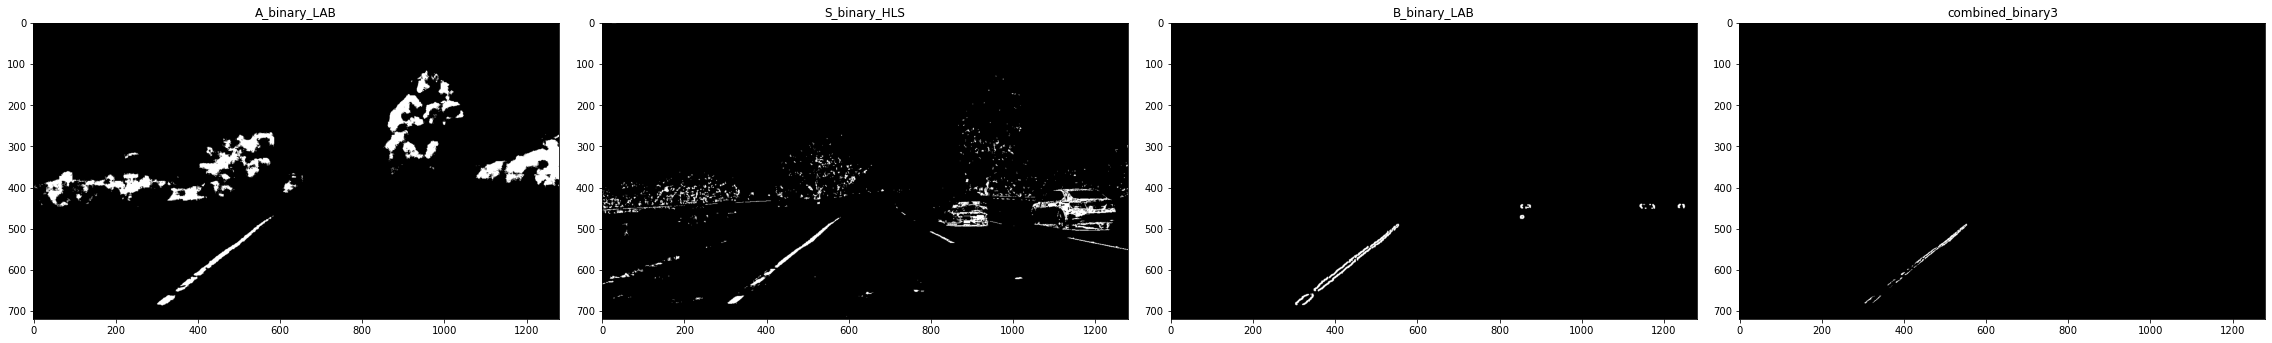

In [49]:
# combined 3 use 'and'

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(31, 11))
f.tight_layout()
ax1.imshow(A_binary_LAB, cmap ='gray')
ax1.set_title('A_binary_LAB')
ax2.imshow(S_binary_HLS, cmap='gray')
ax2.set_title('S_binary_HLS')
ax3.imshow(B_binary_LAB, cmap='gray')
ax3.set_title('B_binary_LAB')
ax4.imshow(combined_binary3, cmap='gray')
ax4.set_title('combined_binary3')
plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)


# f.savefig('../output_images/combined3.jpg')





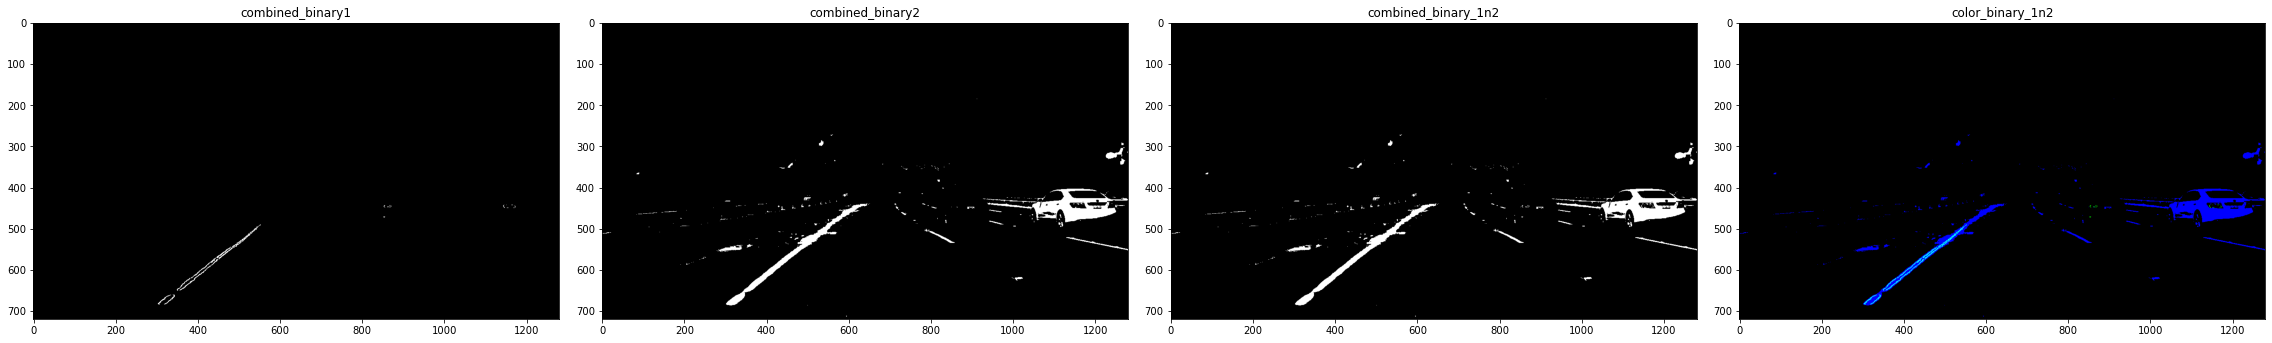

In [50]:
# combined 1 and 2

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(31, 11))
f.tight_layout()
ax1.imshow(combined_binary1, cmap ='gray')
ax1.set_title('combined_binary1')
ax2.imshow(combined_binary2, cmap='gray')
ax2.set_title('combined_binary2')
ax3.imshow(combined_binary_1n2, cmap='gray')
ax3.set_title('combined_binary_1n2')
ax4.imshow(color_binary_1n2)
ax4.set_title('color_binary_1n2')
plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)


# f.savefig('../output_images/combined_1n2.jpg')





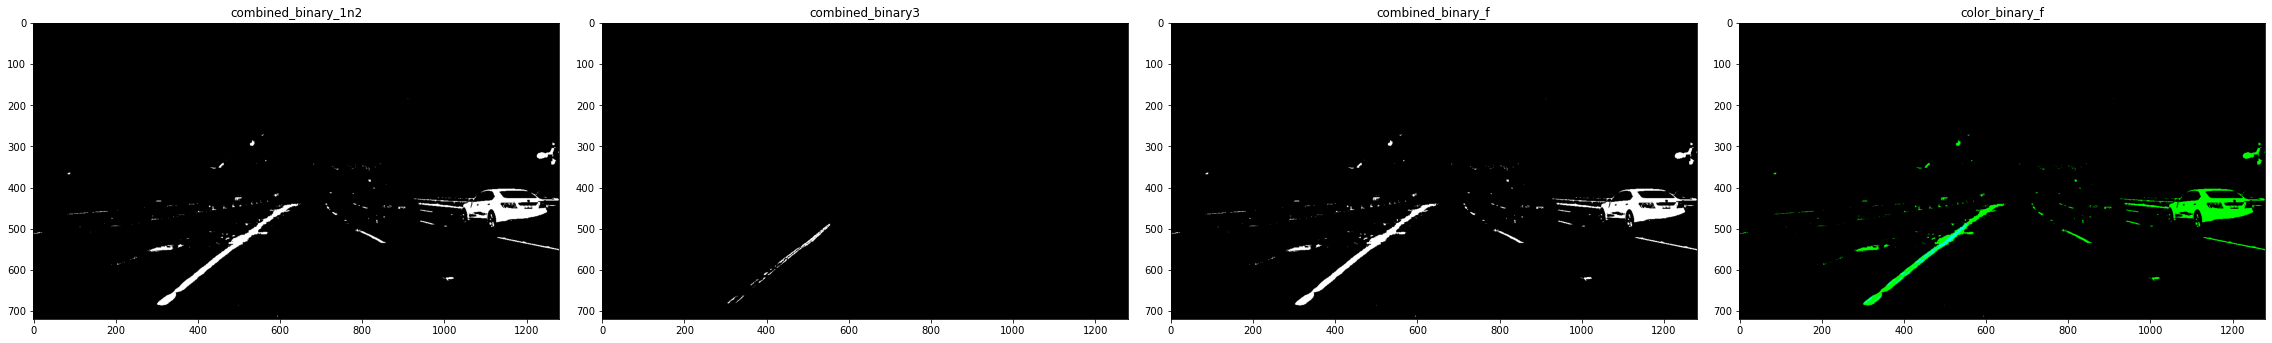

In [51]:
# combined 1n2 and 3

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(31, 11))
f.tight_layout()
ax1.imshow(combined_binary_1n2, cmap ='gray')
ax1.set_title('combined_binary_1n2')
ax2.imshow(combined_binary3, cmap='gray')
ax2.set_title('combined_binary3')
ax3.imshow(combined_binary_f, cmap='gray')
ax3.set_title('combined_binary_f')
ax4.imshow(color_binary_f)
ax4.set_title('color_binary_f')
plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)


# f.savefig('../output_images/combined_1n2_and_3.jpg')





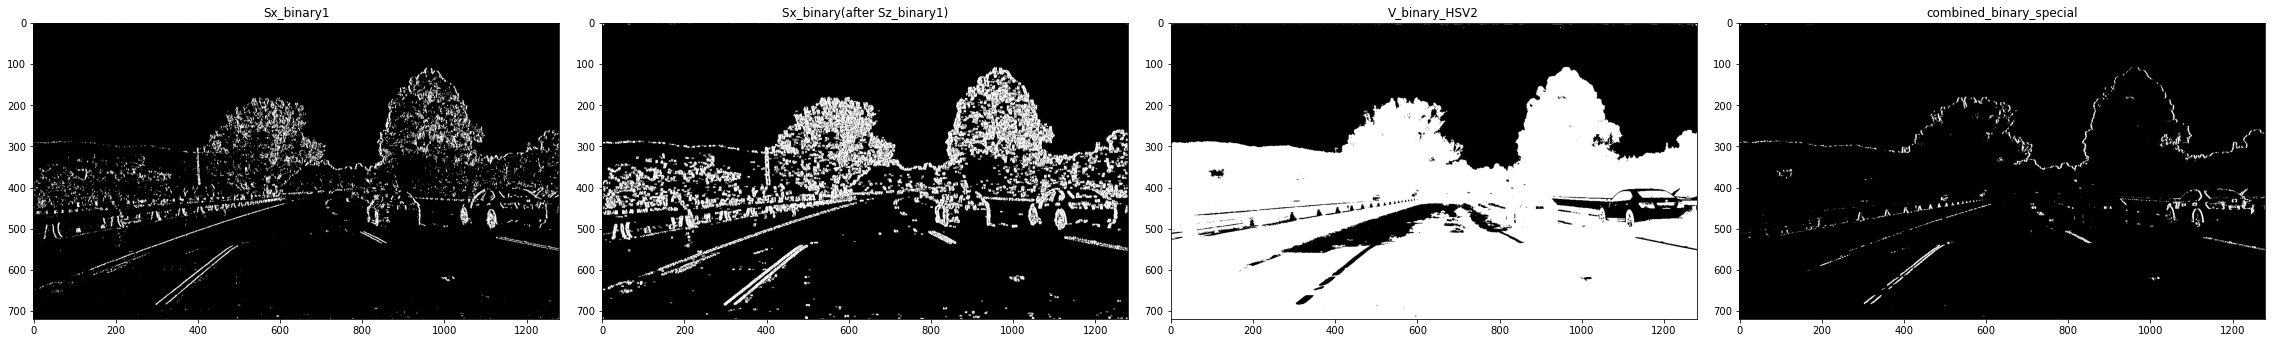

In [52]:
# combined additional: applied two sobel with diff kernel size 
# Reason I add V_binary_HSV2 because it will heple to eliminate noise that I dont want to collect

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(31, 11))
f.tight_layout()
ax1.imshow(Sx_binary1, cmap ='gray')
ax1.set_title('Sx_binary1')
ax2.imshow(Sx_binary, cmap='gray')
ax2.set_title('Sx_binary(after Sz_binary1)')
ax3.imshow(V_binary_HSV2, cmap='gray')
ax3.set_title('V_binary_HSV2')
ax4.imshow(combined_binary_special, cmap='gray')
ax4.set_title('combined_binary_special')
plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)


# f.savefig('../output_images/combined_Sx1_Sx_V_HSV2.jpg')





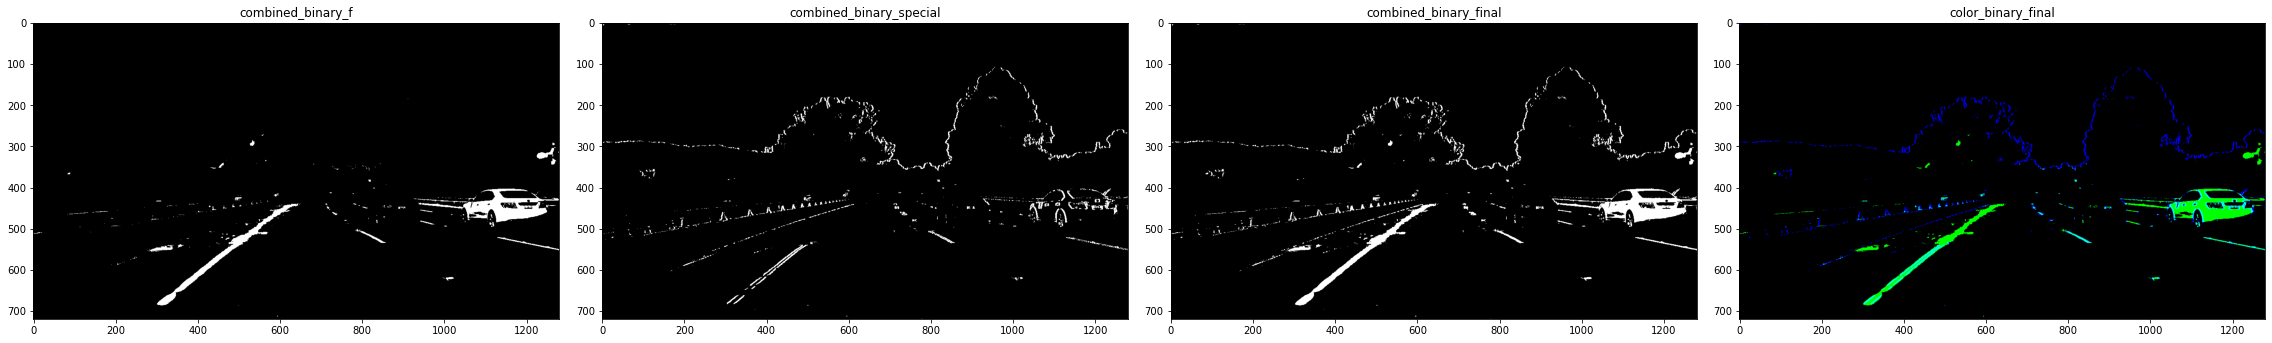

In [53]:
# Combined final and special

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(31, 11))
f.tight_layout()
ax1.imshow(combined_binary_f, cmap ='gray')
ax1.set_title('combined_binary_f')
ax2.imshow(combined_binary_special, cmap='gray')
ax2.set_title('combined_binary_special')
ax3.imshow(combined_binary_final, cmap='gray')
ax3.set_title('combined_binary_final')
ax4.imshow(color_binary_final, cmap='gray')
ax4.set_title('color_binary_final')
plt.subplots_adjust(left = 0., right =1, top =0.9, bottom = 0.)


# f.savefig('../output_images/combined_Last.jpg')





Here is the combined binary image end

# Select